# Gibbs sampling on Probabilistic Count Matrix Factorization

**TODO**: compare the time that Gibbs sampling takes to achieve a certain log-likelihood with CAVI to see who's faster. Then compare with SVI and SGLD.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, gibbs, klqp
import plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.stats import gamma

plt.style.use('ggplot')

## Data generation

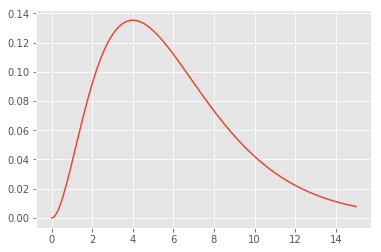

In [2]:
# Look at the Gamma pdf to help deciding the prior parameters for U estimation
a = 3.
b = 0.5

x = np.linspace(0, 15, 1000)

prior_pdf = gamma.pdf(x, a, scale=1./b) 
plt.plot(x, prior_pdf)
plt.show()

In [3]:
# Experiment parameters
N = 100 # number of observations
P = 20 # observation space dimensionality
K = 2 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.1
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p, 
                                                 eps=eps, return_all=True)

# Run PCA
pca = PCA(n_components=2).fit_transform(Y)

# Run Gibbs sampling and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('Gibbs:')
gb = gibbs.GibbsSampling(Y, alpha, beta, pi)
U_samples, _, _, _ = gb.run_gibbs(n_iterations=100, return_likelihood=False, init_prior=True)
# gibbs_U = gb.U # Use the last Gibbs sample of U
gibbs_U = np.mean(U_samples[10:], axis=0) # Use the sample average after the burn-in period

print('\n')

# Run CAVI sampling and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('CAVI:')
cavi = klqp.CoordinateAscentVI(Y, alpha, beta, pi)
cavi.run_cavi(n_iterations=200, return_elbo=False)
cavi_U = cavi.a[0] / cavi.a[1] # VI estimate is the mean of the variational approximation

Gibbs:
Iteration 100/100

CAVI:


In [4]:
# Sanity check
np.all(gb.X == gb.Z.sum(axis=2))

True

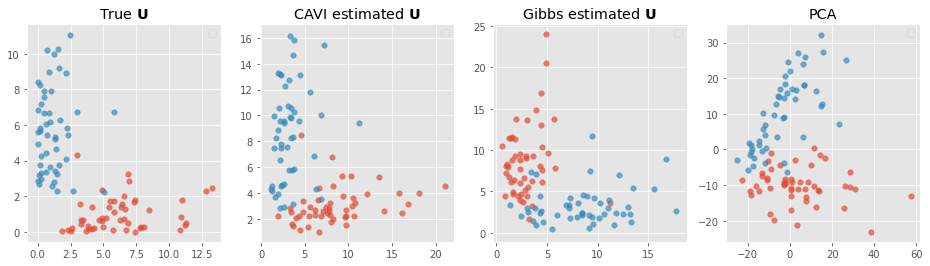

In [8]:
# Plot lower-dimensional embeddings
s = 30
alpha = 0.7
labels=[]
fig = plt.figure(figsize=(16, 4))
ax1 = plt.subplot(1, 4, 1)
handlers = []
for c in range(C):
    h = ax1.scatter(U[0, int(c*N/C):int((c+1)*N/C)], U[1, int(c*N/C):int((c+1)*N/C)], s=s, alpha=alpha)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('True $\mathbf{U}$')

ax2 = plt.subplot(1, 4, 2)
handlers = []
for c in range(C):
    h = ax2.scatter(cavi_U[int(c*N/C):int((c+1)*N/C), 0], cavi_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('CAVI estimated $\mathbf{U}$')

ax3 = plt.subplot(1, 4, 3)
handlers = []
for c in range(C):
    h = ax3.scatter(gibbs_U[int(c*N/C):int((c+1)*N/C), 0], gibbs_U[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax3.legend(handlers, labels, scatterpoints=1)
plt.title('Gibbs estimated $\mathbf{U}$')

ax4 = plt.subplot(1, 4, 4)
handlers = []
for c in range(C):
    h = ax4.scatter(pca[int(c*N/C):int((c+1)*N/C), 0], pca[int(c*N/C):int((c+1)*N/C), 1], s=s, alpha=alpha)
    handlers.append(h)
ax4.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()

In [6]:
true_silh = silhouette_score(U.T, clusters)
cavi_silh = silhouette_score(cavi_U, clusters)
gibbs_silh = silhouette_score(gibbs_U, clusters)
pca_silh = silhouette_score(pca, clusters)

scores = {'CAVI': cavi_silh, 'PCA': pca_silh, 'Gibbs': gibbs_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI: 0.398
- Gibbs: 0.376
- PCA: 0.309

Silhouette of true U:
0.529
